In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/MPI_6.csv")


In [4]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixSize"] = dataFrame["matrixSize"].astype(int)
dataFrame["numProcesses"] = dataFrame["numProcesses"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)
dataFrame["sendMode"] = dataFrame["sendMode"].astype(str)

print("Loaded rows:", len(dataFrame))
print("Send modes:", dataFrame["sendMode"].unique())
print("Matrix sizes:", sorted(dataFrame["matrixSize"].unique()))
print("Process counts:", sorted(dataFrame["numProcesses"].unique()))
dataFrame.head(8)


Loaded rows: 625
Send modes: ['collective' 'manual_std' 'manual_ssend' 'manual_bsend' 'manual_rsend']
Matrix sizes: [240, 480, 720, 960, 1200]
Process counts: [1, 4, 9, 16, 25]


,testType,matrixSize,numProcesses,sendMode,timeSeconds,checksum,runIndex,mpiEnv
0,MPI_6,240,1,collective,0.018621,3.471298e+06,2,SLURM_NTASKS=1;JOBID=15186
1,MPI_6,240,1,collective,0.014912,3.463737e+06,3,SLURM_NTASKS=1;JOBID=15187
2,MPI_6,240,1,collective,0.014897,3.445727e+06,5,SLURM_NTASKS=1;JOBID=15189
3,MPI_6,240,1,collective,0.019421,3.451101e+06,4,SLURM_NTASKS=1;JOBID=15188
4,MPI_6,240,1,manual_std,0.014884,3.452468e+06,1,SLURM_NTASKS=1;JOBID=15190
5,MPI_6,240,1,manual_std,0.014783,3.452800e+06,2,SLURM_NTASKS=1;JOBID=15191
6,MPI_6,240,1,manual_std,0.014848,3.442106e+06,3,SLURM_NTASKS=1;JOBID=15192
7,MPI_6,240,1,manual_std,0.019361,3.451779e+06,4,SLURM_NTASKS=1;JOBID=15193


In [5]:
groupedFrame = dataFrame.groupby(["sendMode","matrixSize","numProcesses"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["sendMode","matrixSize","numProcesses"]).reset_index(drop=True)
groupedFrame.head(12)


,sendMode,matrixSize,numProcesses,median,mean,std,count
0,collective,240,1,0.015759,0.016722,0.002146,5
1,collective,240,4,0.010255,0.009371,0.001717,5
2,collective,240,9,0.011529,0.011317,0.000954,5
3,collective,240,16,0.014526,0.013589,0.002378,5
4,collective,240,25,0.053388,0.054053,0.002085,5
5,collective,480,1,0.116610,0.116654,0.002851,5
6,collective,480,4,0.042057,0.047841,0.010287,5
7,collective,480,9,0.040647,0.038145,0.004351,5
8,collective,480,16,0.049967,0.050012,0.003536,5
9,collective,480,25,0.084447,0.083411,0.002598,5


In [6]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (sendModeVal, matrixSizeVal), subFrame in groupedDf.groupby(["sendMode","matrixSize"]):
        baseRows = subFrame[subFrame["numProcesses"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        sf = subFrame.copy()
        sf["speedup"] = baseTime / sf["median"]
        sf["efficiency"] = sf["speedup"] / sf["numProcesses"]
        frames.append(sf)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)


,sendMode,matrixSize,numProcesses,median,mean,std,count,speedup,efficiency
0,collective,240,1,0.015759,0.016722,0.002146,5,1.000000,1.000000
1,collective,240,4,0.010255,0.009371,0.001717,5,1.536714,0.384178
2,collective,240,9,0.011529,0.011317,0.000954,5,1.366901,0.151878
3,collective,240,16,0.014526,0.013589,0.002378,5,1.084882,0.067805
4,collective,240,25,0.053388,0.054053,0.002085,5,0.295179,0.011807
5,collective,480,1,0.116610,0.116654,0.002851,5,1.000000,1.000000
6,collective,480,4,0.042057,0.047841,0.010287,5,2.772666,0.693166
7,collective,480,9,0.040647,0.038145,0.004351,5,2.868846,0.318761
8,collective,480,16,0.049967,0.050012,0.003536,5,2.333740,0.145859
9,collective,480,25,0.084447,0.083411,0.002598,5,1.380866,0.055235


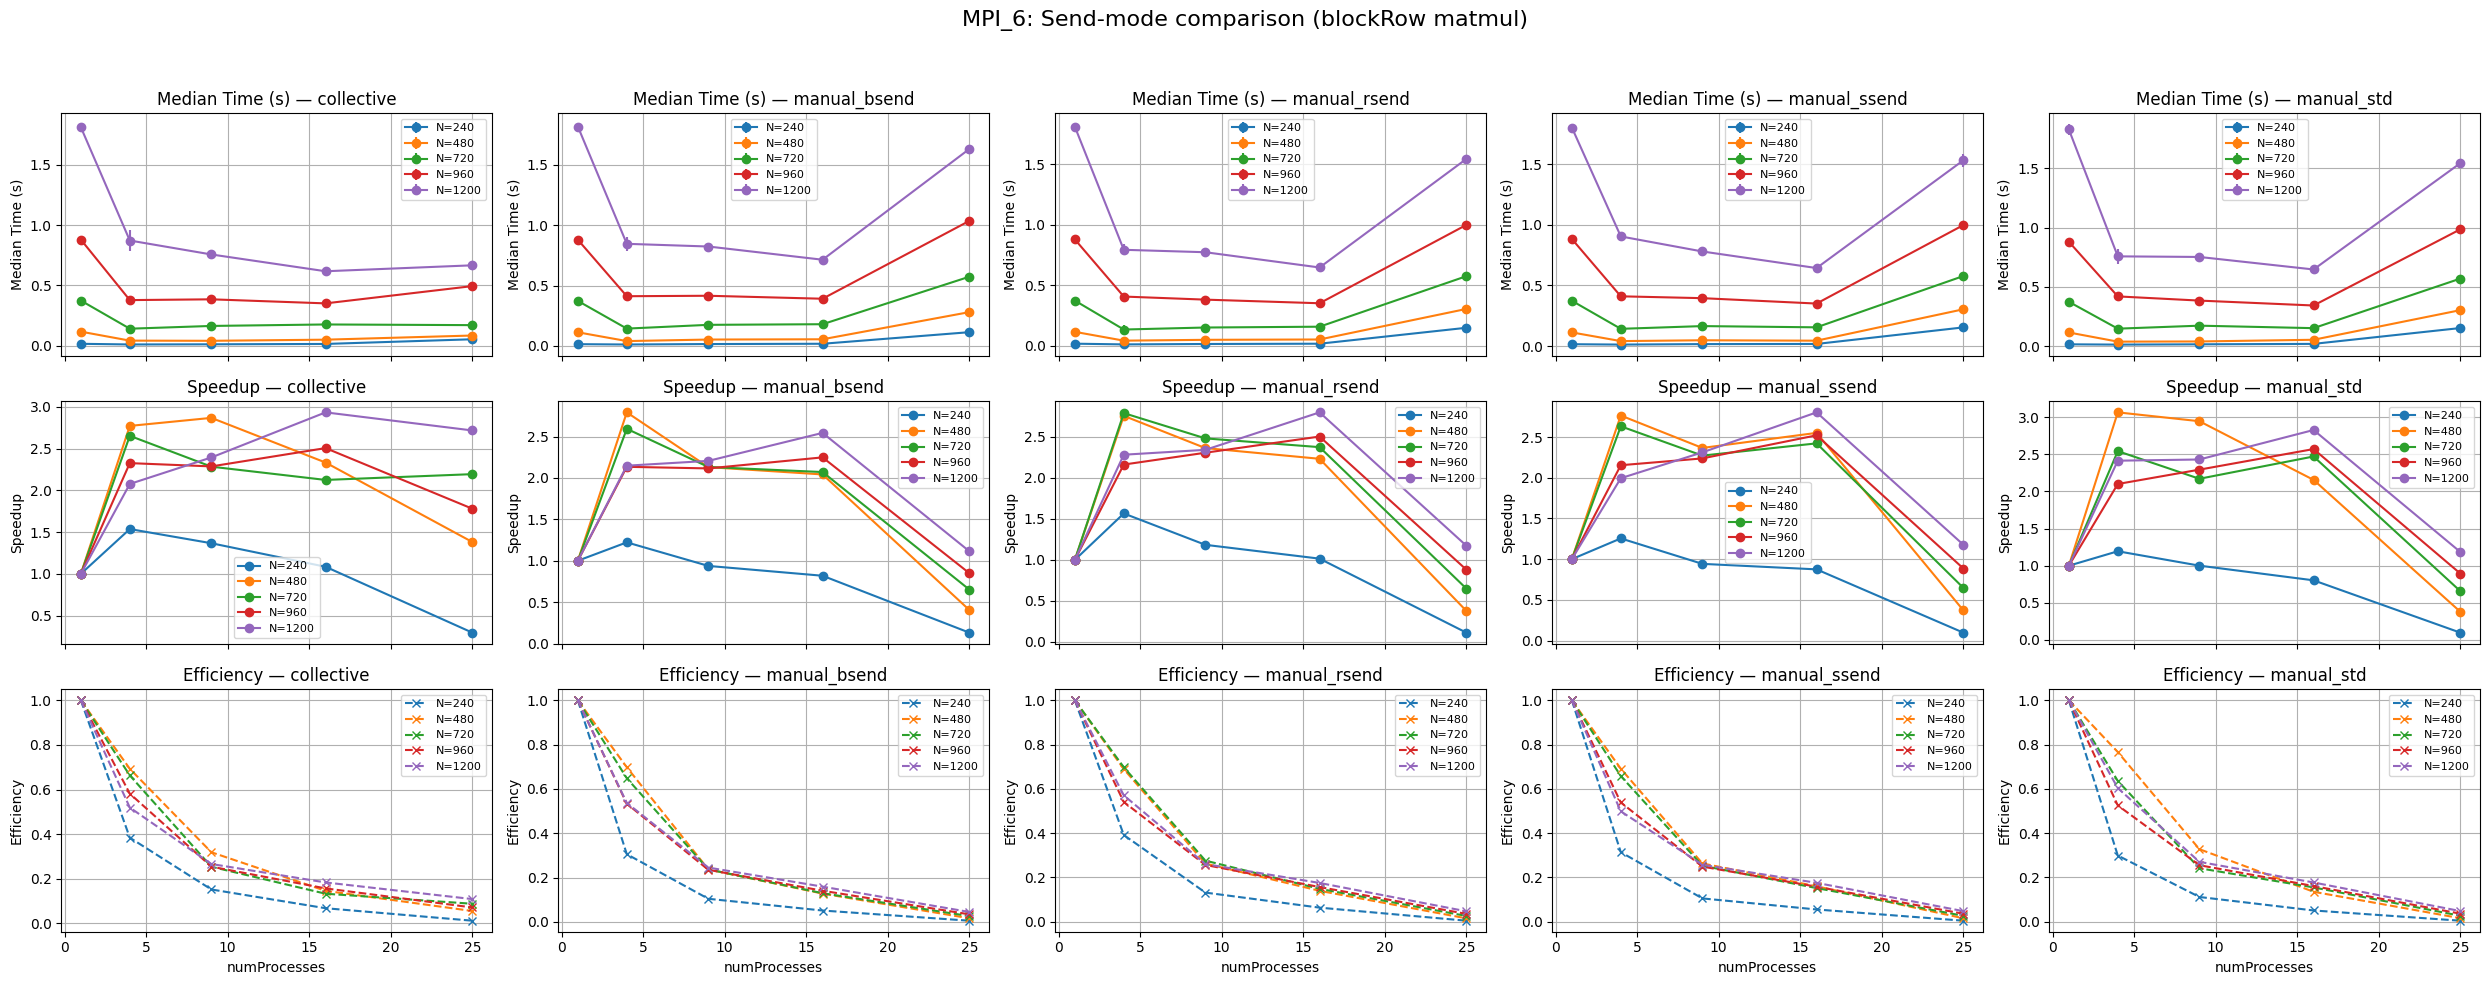

In [7]:
modes = sorted(perfFrame["sendMode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

matrixSizes = sorted(perfFrame["matrixSize"].unique())

fig, axes = plt.subplots(len(metrics), len(modes), figsize=(5 * max(1, len(modes)), 10), sharex=True)
if len(modes) == 1:
    axes2d = np.array([[axes[i]] for i in range(len(metrics))])
else:
    axes2d = axes

for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        ax = axes2d[rowIdx][colIdx]
        anyPlotted = False
        for matrixSizeVal in matrixSizes:
            subFrame = perfFrame[(perfFrame["sendMode"] == modeVal) & (perfFrame["matrixSize"] == matrixSizeVal)].sort_values("numProcesses")
            if subFrame.empty:
                continue
            anyPlotted = True
            x = subFrame["numProcesses"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={matrixSizeVal}")

        if not anyPlotted:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == len(metrics) - 1:
            ax.set_xlabel("numProcesses")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)

plt.suptitle("MPI_6: Send-mode comparison (blockRow matmul)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [8]:
summaryRows = []
for (sendModeVal, matrixSizeVal), sub in perfFrame.groupby(["sendMode","matrixSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestProcs = int(argMax["numProcesses"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numProcesses"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "sendMode": sendModeVal,
        "matrixSize": matrixSizeVal,
        "bestNumProcesses": bestProcs,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Proc": medianAtOne
    })

summaryFrame = pd.DataFrame(summaryRows).sort_values(["sendMode","matrixSize"])
display(summaryFrame)


,sendMode,matrixSize,bestNumProcesses,maxSpeedup,efficiencyAtBest,medianTime1Proc
0,collective,240,4,1.536714,0.384178,0.015759
1,collective,480,9,2.868846,0.318761,0.116610
2,collective,720,4,2.653741,0.663435,0.374403
3,collective,960,16,2.506743,0.156671,0.880105
4,collective,1200,16,2.934873,0.183430,1.812372
5,manual_bsend,240,4,1.222022,0.305506,0.014938
6,manual_bsend,480,4,2.792051,0.698013,0.113173
7,manual_bsend,720,4,2.593483,0.648371,0.372834
8,manual_bsend,960,16,2.248392,0.140524,0.878631
9,manual_bsend,1200,16,2.544065,0.159004,1.815300
